In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS =3
EPOCHS= 50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "plant village",
    shuffle=True,
    
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


In [4]:
classnames = dataset.class_names
classnames

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
len(dataset)

645

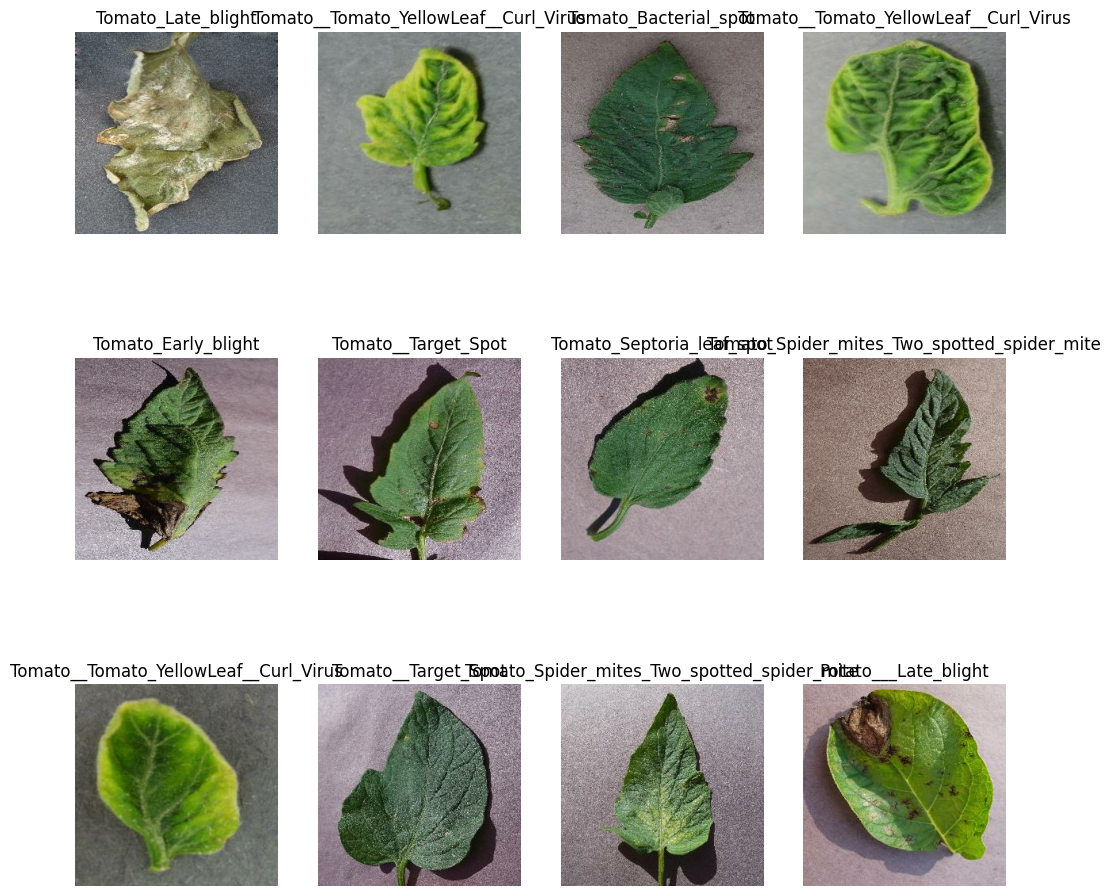

In [6]:
plt.figure(figsize=(12,12))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classnames[label_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

645

In [8]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [9]:
train_size = 0.8
len(dataset)*train_size

516.0

In [10]:
train_ds = dataset.take(516)
len(train_ds)

516

In [11]:
test_ds = dataset.skip(516)
len(test_ds)

129

In [12]:
val_size = 0.1
len(dataset)*val_size

64.5

In [13]:
val_size = test_ds.take(64)
len(val_size)

64

In [14]:
test_ds = test_ds.skip(64)
len(test_ds)

65

In [15]:
def get_dataset_paritions_tf (ds,train_split = 0.8,val_split = 0.1, test_split = 0.1,shuffle=True,shuffle_size=10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)

    train_size = int(train_split* ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [16]:
train_ds,val_ds,test_ds = get_dataset_paritions_tf(dataset)

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
len(train_ds)

516

In [19]:
len(val_ds)

64

In [20]:
len(test_ds)

65

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale =tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE , IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [24]:
input_shape = (BATCH_SIZE , IMAGE_SIZE , IMAGE_SIZE , CHANNELS)
n_classes =15 #five catergories

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32 , (4,4), activation = 'relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(145 ,(4,4), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(145,(4,4), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(145 ,(4,4), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(145 ,(4,4), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(145 ,(4,4), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(145, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 253, 253, 32)        1568      
                                                                 
 max_pooling2d (MaxPooling2  (32, 126, 126, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 123, 123, 145)       74385     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 61, 61, 145)         0         
 g2D)                                                 

In [26]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose =1,
    epochs = EPOCHS
)

Epoch 1/50


c:\Users\riddh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(




516/516 [==============================] - 1478s 3s/step - loss: 2.0859 - accuracy: 0.3050 - val_loss: 1.6628 - val_accuracy: 0.4434
Epoch 2/50
516/516 [==============================] - 1413s 3s/step - loss: 1.4149 - accuracy: 0.5214 - val_loss: 1.2010 - val_accuracy: 0.5752
Epoch 3/50
516/516 [==============================] - 1189s 2s/step - loss: 0.9765 - accuracy: 0.6604 - val_loss: 1.2266 - val_accuracy: 0.5947
Epoch 4/50
516/516 [==============================] - 1187s 2s/step - loss: 0.7109 - accuracy: 0.7516 - val_loss: 0.7671 - val_accuracy: 0.7188
Epoch 5/50
516/516 [==============================] - 1260s 2s/step - loss: 0.5845 - accuracy: 0.7957 - val_loss: 0.6062 - val_accuracy: 0.7837
Epoch 6/50
516/516 [==============================] - 1222s 2s/step - loss: 0.4968 - accuracy: 0.8242 - val_loss: 0.4889 - val_accuracy: 0.8169
Epoch 7/50
516/516 [==============================] - 1180s 2s/step - loss: 0.4033 - accuracy: 0.8599 - val_loss: 0.3989 - val_accuracy: 0.8613
E

In [28]:
scores = model.evaluate(test_ds)

65/65 [==============================] - 100s 564ms/step - loss: 0.0986 - accuracy: 0.9663


In [29]:
scores

[0.09863509237766266, 0.9663461446762085]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 516}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

first image to predict
actual label : Tomato_healthy
1/1 [==============================] - 1s 873ms/step
predicyted label: Tomato_healthy


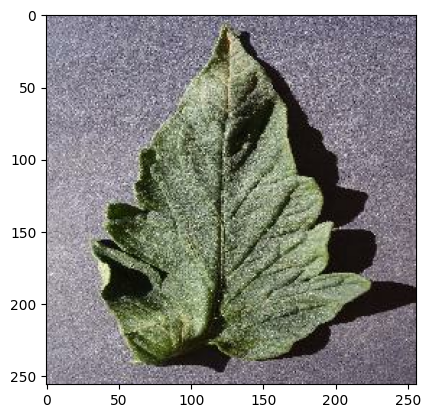

In [33]:
import numpy as np
for image_batch , label_batch in test_ds.take(1):

    first_image  = image_batch[0].numpy().astype('uint8')
    first_label  = label_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label :",classnames[first_label])

    batch_prediction = model.predict(image_batch)
    print("predicyted label:",classnames[np.argmax(batch_prediction[0])])

In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)

    predictions = model.predict(img_array)

    predicted_class = classnames[np.argmax(predictions[0])]
    confidense = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidense

1/1 [==============================] - 0s 60ms/step


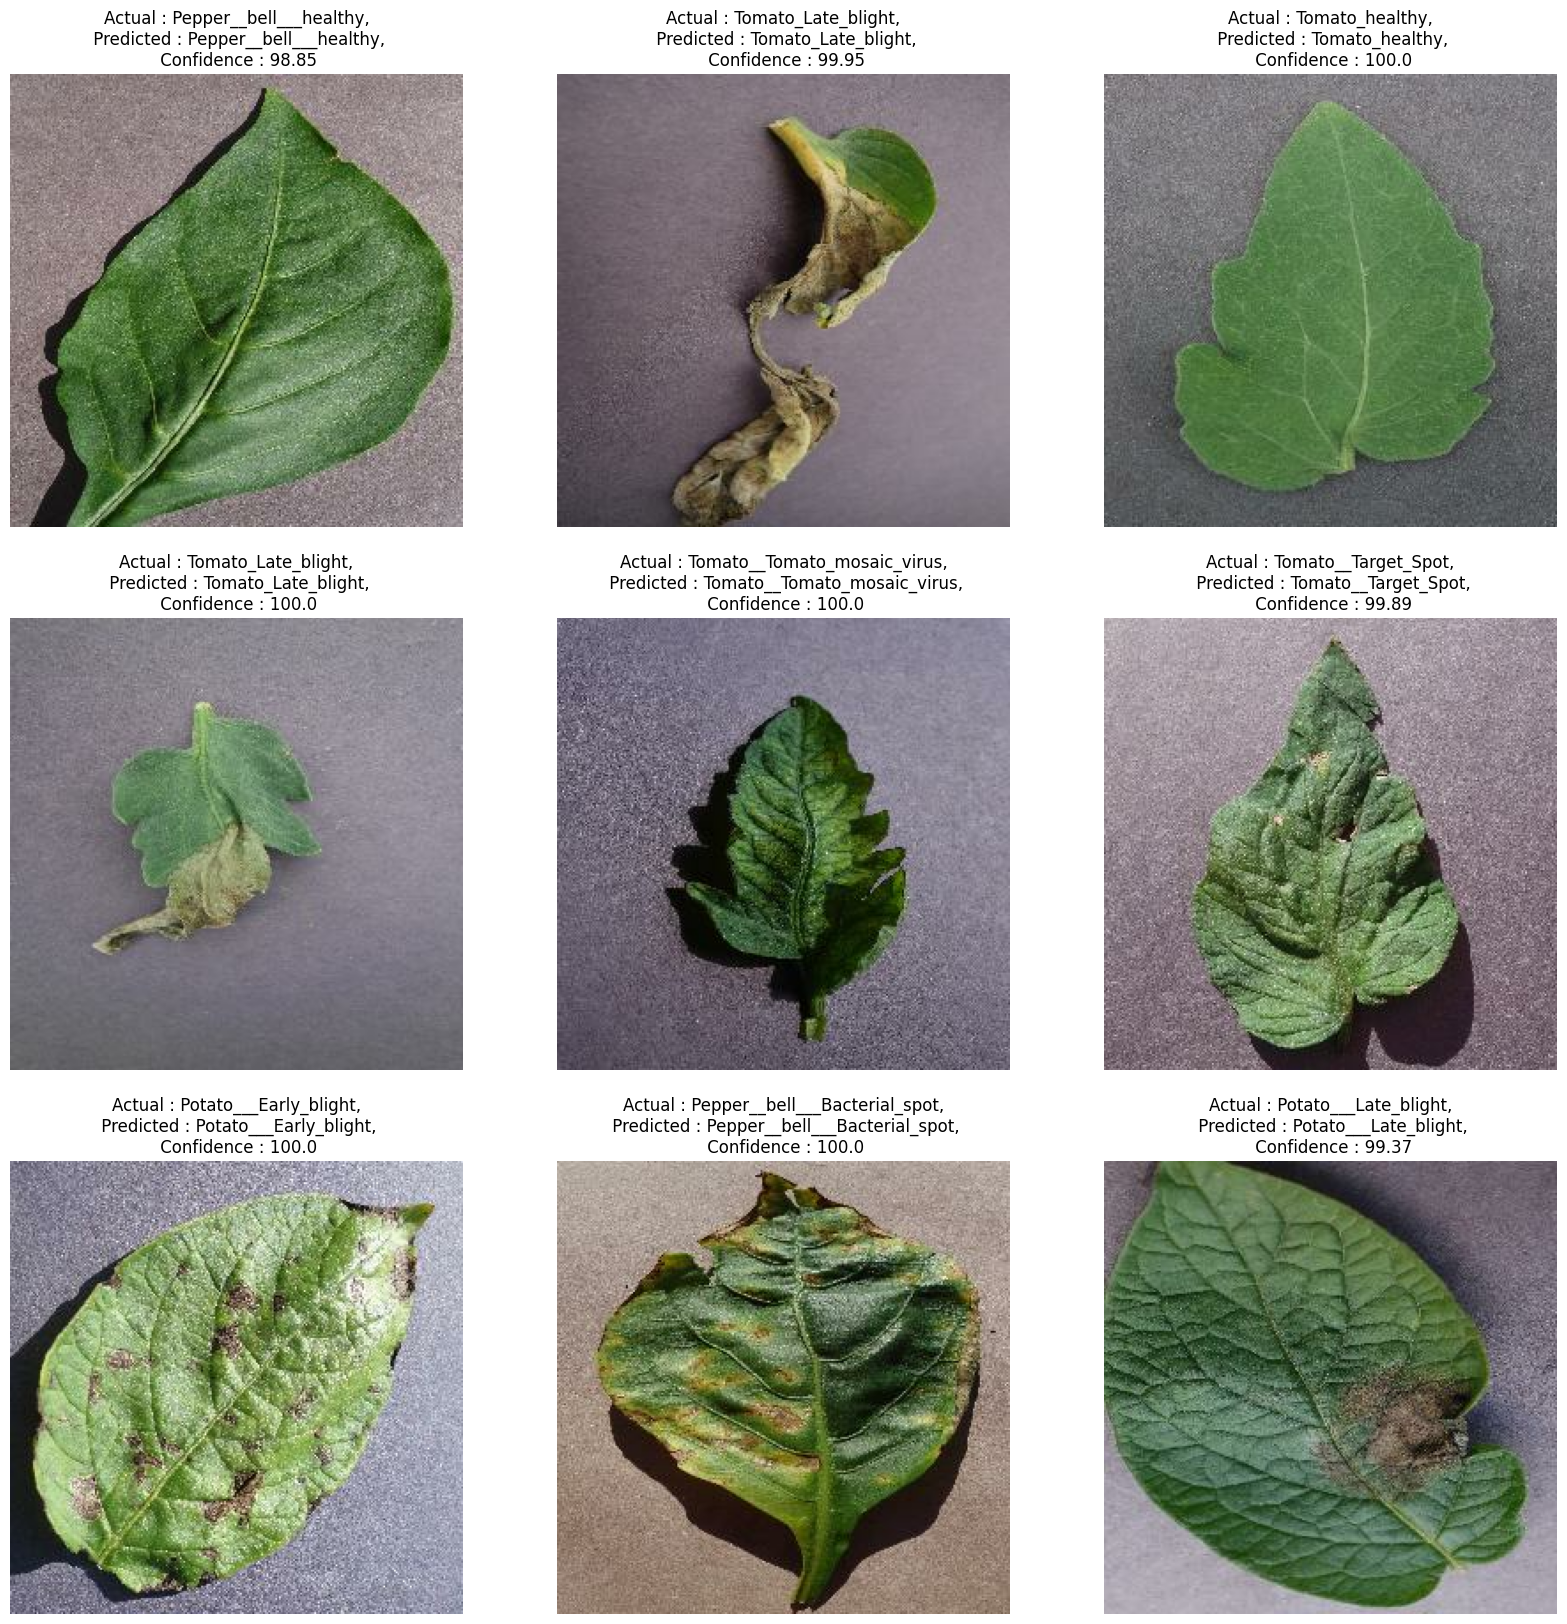

In [35]:
plt.figure(figsize=(20,20))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax =plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class , confidence = predict(model, images[i].numpy)
        actual_class = classnames[labels[i]]

        plt.title(f"Actual : {actual_class},\n Predicted : {predicted_class},\n Confidence : {confidence}")
        
        plt.axis("off")

In [36]:
import os

# Get the list of files in the directory
files = os.listdir("../saved_models")

# Filter out non-numeric filenames and convert the remaining ones to integers
model_versions = [int(i) for i in files if i.isdigit()]

# Determine the next model version
model_version = max(model_versions + [0]) + 1

# Save the model
model.save(f"../saved_models/{model_version}.h5")


c:\Users\riddh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
